In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/intern_learning_data.csv")
df

,intern_id,course_id,rating
0,1,110,2
1,1,105,3
2,1,119,4
3,1,111,3
4,1,101,2
...,...,...,...
65,10,102,5
66,10,105,1
67,10,114,3
68,10,111,3


In [3]:
# Create user-item matrix
user_item_matrix = df.pivot_table(index='intern_id', columns='course_id', values='rating').fillna(0)


In [4]:
class MatrixFactorization:
    def __init__(self, R, K, alpha, beta, iterations):  # <-- Fixed here
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        for _ in range(self.iterations):
            np.random.shuffle(self.samples)
            for i, j, r in self.samples:
                prediction = self.get_prediction(i, j)
                e = r - prediction

                self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
                self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

                self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i, :])
                self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j, :])

    def get_prediction(self, i, j):
        return self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)

    def full_matrix(self):
        return self.b + self.b_u[:, np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)


In [5]:
R = user_item_matrix.values
mf = MatrixFactorization(R, K=5, alpha=0.01, beta=0.01, iterations=50)
mf.train()

predicted_ratings = mf.full_matrix()

interns = user_item_matrix.index
courses = user_item_matrix.columns
recommendations = []

In [6]:
for i, intern in enumerate(interns):
    rated_courses = set(np.where(R[i] > 0)[0])
    predictions = [(j, predicted_ratings[i, j]) for j in range(len(courses)) if j not in rated_courses]
    top_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:3]
    for j, score in top_preds:
        recommendations.append({
            'intern_id': intern,
            'recommended_course_id': courses[j],
            'predicted_rating': round(score, 2)
        })

recommendations_df = pd.DataFrame(recommendations)
print("Top Recommended Learning Paths:")
print(recommendations_df.head(15))


Top Recommended Learning Paths:
    intern_id  recommended_course_id  predicted_rating
0           1                    104              3.94
1           1                    117              3.80
2           1                    115              3.71
3           2                    114              4.33
4           2                    115              4.00
5           2                    102              3.94
6           3                    120              4.62
7           3                    102              4.45
8           3                    115              4.34
9           4                    120              3.61
10          4                    117              3.48
11          4                    103              3.32
12          5                    117              4.31
13          5                    111              4.26
14          5                    102              4.08


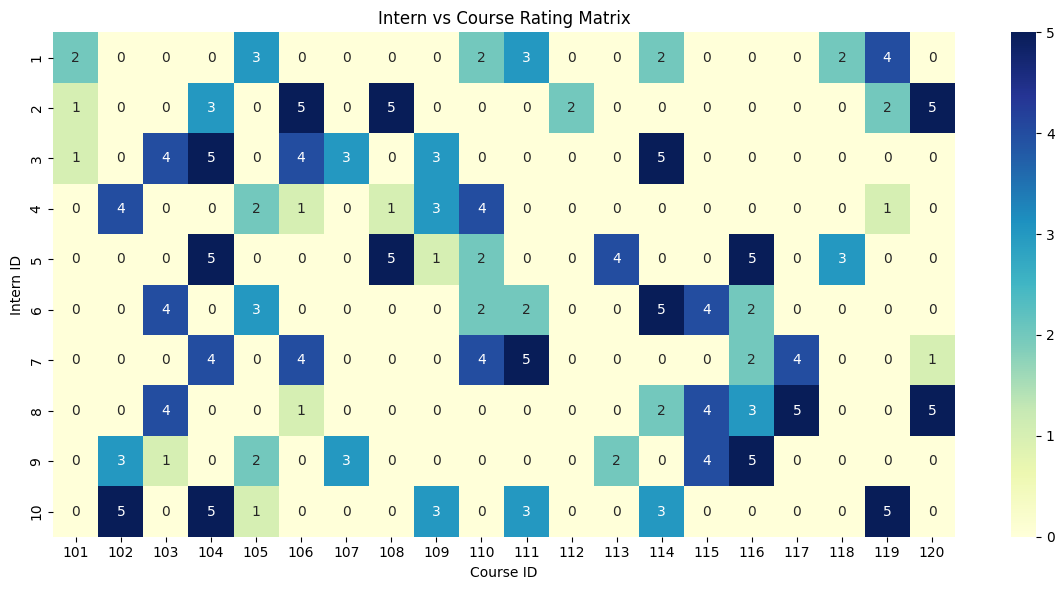

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of original user-item matrix
plt.figure(figsize=(12, 6))
sns.heatmap(user_item_matrix, annot=True, cmap="YlGnBu")
plt.title("Intern vs Course Rating Matrix")
plt.xlabel("Course ID")
plt.ylabel("Intern ID")
plt.tight_layout()
plt.show()

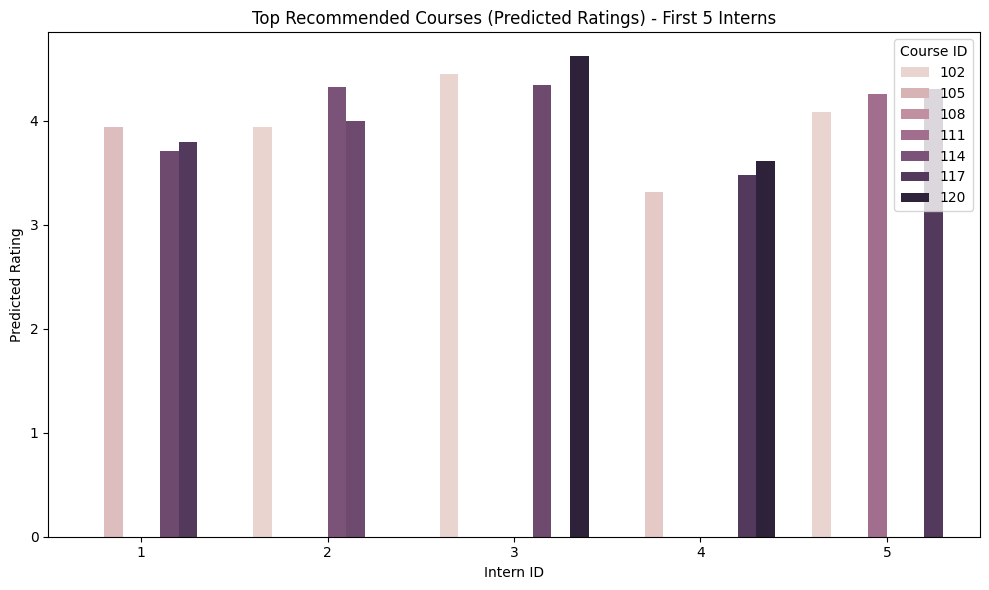

In [8]:
# Top recommended courses per intern (first 5 interns)
plt.figure(figsize=(10, 6))
sample = recommendations_df[recommendations_df['intern_id'].isin(interns[:5])]
sns.barplot(data=sample, x='intern_id', y='predicted_rating', hue='recommended_course_id')
plt.title("Top Recommended Courses (Predicted Ratings) - First 5 Interns")
plt.xlabel("Intern ID")
plt.ylabel("Predicted Rating")
plt.legend(title="Course ID")
plt.tight_layout()
plt.show()

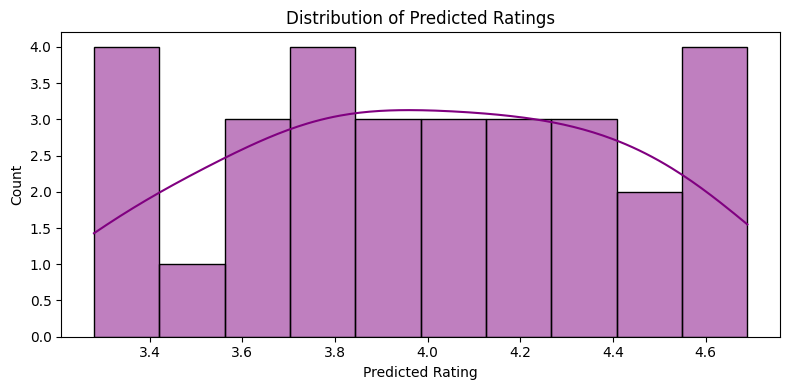

In [9]:
# Distribution of predicted ratings
plt.figure(figsize=(8, 4))
sns.histplot(recommendations_df['predicted_rating'], bins=10, kde=True, color="purple")
plt.title("Distribution of Predicted Ratings")
plt.xlabel("Predicted Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()